## Poisson Process Sessions

The goal of the notebook is to learn the rate of the Poisson Process (PP) in application to modeling user session length. In a Poisson Process [1], the inter-arrival times (session lengths) are assumed to be independent and identically distributed (iid) exponential random variables, while the number (or count) of events is distributed as a Poisson random variable:

$$x_i \sim \mathrm{Exp}(\lambda)= \lambda \exp\{-\lambda x\}$$

$$\mathrm{Poiss}(k;\lambda, t) = \frac{(\lambda t)^{k}}{k!}\exp\{-\lambda t\}$$

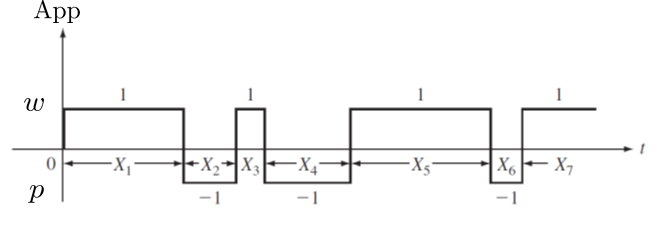

In [4]:
from IPython.display import Image
Image("figures/random_process.png")

The figure above shows the variable length session windows: $\{x_1,...,x_k\}$ of alternating switching process between (w)ork and (p)lay events. Given the training data, our goal is to learn the arrival rate $\lambda$ that captures an average frequency of sessions. We can use Monte Carlo sampling methods and in particular PyMC3 library [2] to do that. Note: we can also look at non-homogenuous Poisson process where the arrival rate lambda is a function of time: $\lambda(t)$

In [16]:
%matplotlib inline
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import pymc3 as pm

import theano
import theano.tensor as tt

import warnings
warnings.filterwarnings('ignore')

In [117]:
#load data
print("loading data...")
train_df = pd.read_csv('./data/OrdonezA_ADLs.txt', sep='\t\t')
train_df.head()

loading data...


,Start,End,Activity
0,2011-11-28 02:27:59,2011-11-28 10:18:11,Sleeping
1,2011-11-28 10:21:24,2011-11-28 10:23:36,Toileting
2,2011-11-28 10:25:44,2011-11-28 10:33:00,Showering
3,2011-11-28 10:34:23,2011-11-28 10:43:00,Breakfast
4,2011-11-28 10:49:48,2011-11-28 10:51:13,Grooming


Let's convert start and end times to pandas datetime:

In [118]:
train_df['Start'] = pd.to_datetime(train_df['Start'])
train_df['End'] = pd.to_datetime(train_df['End'])
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 3 columns):
Start       248 non-null datetime64[ns]
End         248 non-null datetime64[ns]
Activity    248 non-null object
dtypes: datetime64[ns](2), object(1)
memory usage: 5.9+ KB


In [119]:
train_df.head()

,Start,End,Activity
0,2011-11-28 02:27:59,2011-11-28 10:18:11,Sleeping
1,2011-11-28 10:21:24,2011-11-28 10:23:36,Toileting
2,2011-11-28 10:25:44,2011-11-28 10:33:00,Showering
3,2011-11-28 10:34:23,2011-11-28 10:43:00,Breakfast
4,2011-11-28 10:49:48,2011-11-28 10:51:13,Grooming


Let's compute time intervals between activity start times and a maximum likelihood estimate for lambda: $\lambda = \frac{1}{E[X_i]} = \frac{1}{ \frac{1}{n}\sum_{i=1}^{n}x_i}$

In [120]:
train_df['delta'] = train_df['Start'].shift(-1) - train_df['Start']
train_df['delta_sec'] = list(map(lambda x: x.seconds, train_df['delta']))
train_df['delta_min'] = list(map(lambda x: x.seconds/60.0, train_df['delta']))
train_df['lambda_est_hz'] = 1.0 / (train_df['delta_sec'].cumsum() / (train_df['delta_sec'].index.values +1))
train_df['activity_cnt'] = np.arange(1,train_df.shape[0]+1)

In [121]:
train_df.head()

,Start,End,Activity,delta,delta_sec,delta_min,lambda_est_hz,activity_cnt
0,2011-11-28 02:27:59,2011-11-28 10:18:11,Sleeping,07:53:25,28405.0,473.416667,0.000035,1
1,2011-11-28 10:21:24,2011-11-28 10:23:36,Toileting,00:04:20,260.0,4.333333,0.000070,2
2,2011-11-28 10:25:44,2011-11-28 10:33:00,Showering,00:08:39,519.0,8.650000,0.000103,3
3,2011-11-28 10:34:23,2011-11-28 10:43:00,Breakfast,00:15:25,925.0,15.416667,0.000133,4
4,2011-11-28 10:49:48,2011-11-28 10:51:13,Grooming,00:01:53,113.0,1.883333,0.000165,5


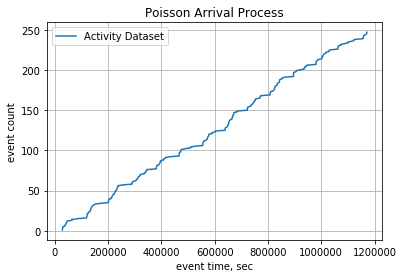

In [126]:
plt.plot(train_df['delta_sec'].cumsum(), train_df['activity_cnt'], label='Activity Dataset')
plt.xlabel("event time, sec"); plt.ylabel("event count"); plt.grid(True); plt.title("Poisson Arrival Process"); plt.legend()

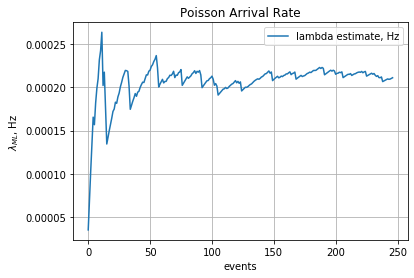

In [128]:
plt.plot(train_df['lambda_est_hz'], label='lambda estimate, Hz')
plt.xlabel("events"); plt.ylabel("$\lambda_{ML}$, Hz"); plt.grid(True); plt.title("Poisson Arrival Rate"); plt.legend()

Let's build a probabilistic model to infer the Poisson rate lambda using PyMC3:

In [136]:
lambda_est = train_df['lambda_est_hz'].mean()

with pm.Model() as model:
    #lambda_prior = pm.Uniform('lambda_prior', 0, 0.001)
    lambda_prior = pm.Normal('lambda_prior', mu = lambda_est, sd = 0.1)
    y_obs = pm.Exponential('y_obs', lam = lambda_prior, observed = train_df['delta_sec'])

with model:
    trace = pm.sample(200, chains = 2, tune = 100)
    pm.traceplot(trace)
    plt.show()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [y_obs_missing, lambda_prior]
Sampling 2 chains: 100%|██████████████████████████████████████████████████████████| 600/600 [18:26<00:00,  1.84s/draws]
The acceptance probability does not match the target. It is 0.9314882386638504, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9401518874543332, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


ImportError: ArviZ is not installed. In order to use `plot_trace`:
pip install arviz

In [74]:
train_df.head()

,Start,End,Activity,delta,delta_min,delta_sec
0,2011-11-28 02:27:59,2011-11-28 10:18:11,Sleeping,07:53:25,473.416667,28405.0
1,2011-11-28 10:21:24,2011-11-28 10:23:36,Toileting,00:04:20,4.333333,260.0
2,2011-11-28 10:25:44,2011-11-28 10:33:00,Showering,00:08:39,8.650000,519.0
3,2011-11-28 10:34:23,2011-11-28 10:43:00,Breakfast,00:15:25,15.416667,925.0
4,2011-11-28 10:49:48,2011-11-28 10:51:13,Grooming,00:01:53,1.883333,113.0


### References

[1] J. Kingman, "Poisson Processes", Oxford Studies in Probability, Clarendon Press, 1993  
[2] A. Patil et al. PyMC: Bayesian Stochastic Modelling in Python, Journal of Statistical Software, 2010